In [15]:
import gzip
import numpy
import urllib
import scipy.optimize
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)
data = list(readGz("reviews_Electronics_5.json.gz"))

In [3]:
random.shuffle(data)
data[0]

{'reviewerID': 'A2DKVFYCQAICA0',
 'asin': 'B005KK41ZK',
 'reviewerName': 'S. Shukla',
 'helpful': [0, 0],
 'reviewText': 'I lost mine at the Zoo..Got this for my Canon T3i and they are perfect fit and tight enough to not fall . No complaints.',
 'overall': 5.0,
 'summary': 'Perfect!!',
 'unixReviewTime': 1372032000,
 'reviewTime': '06 24, 2013'}

In [4]:
len(data)

1689188

In [5]:
train_data = data[:560000]
validation_data = data[560000:1120000]

In [6]:
# Encode itemID and reviewerID
reviewerID_str = list(set([elmt['reviewerID'] for elmt in train_data]))
itemID_str = list(set([elmt['asin'] for elmt in train_data])) 
number_of_reviewers = len(reviewerID_str)
number_of_itemID = len(itemID_str)
reviewerIDs = dict(zip(reviewerID_str,range(number_of_reviewers))) 
itemIDs = dict(zip(itemID_str, range(number_of_itemID)))

In [7]:
R = numpy.zeros((number_of_reviewers,number_of_itemID))
reviewer_to_item = defaultdict(list)
item_to_reviewer = defaultdict(list)

for elmt in train_data:
    reviewerID = reviewerIDs[elmt['reviewerID']]
    itemID = itemIDs[elmt['asin']]
    R[reviewerID][itemID] = elmt['overall']
    reviewer_to_item[reviewerID].append(itemID)
    item_to_reviewer[itemID].append(reviewerID)

def compute_MSE(predictions,y):
    return numpy.dot((predictions-y),(predictions-y).T)/float(len(y))

def predict(elmt,beta_u, beta_i, alpha):
    try:
        reviewerID = reviewerIDs[elmt['reviewerID']]
        itemID = itemIDs[elmt['asin']]
        return alpha+beta_u[reviewerID]+beta_i[itemID]
    except:
        return alpha
    
def gradient_descent(x_train,beta_u,beta_i,alpha,lam):
    i = 0
    while i<2:
        i+=1
        for j in range(len(x_train)):
            reviewerID,itemID = x_train[j]
            reviewer_items = reviewer_to_item[reviewerID]
            beta_u[reviewerID] = (R[reviewerID,reviewer_items].sum()-alpha*len(reviewer_items)-beta_i[reviewer_items].sum())/(lam+len(reviewer_items))
            item_reviewers = item_to_reviewer[itemID]
            beta_i[itemID] = (R[item_reviewers,itemID].sum()-alpha*len(item_reviewers)-beta_u[item_reviewers].sum())/(lam+len(item_reviewers))
    return alpha, beta_i, beta_u

def features(elmt):
    reviewerID = elmt['reviewerID']
    itemID = elmt['asin']
    return [reviewerIDs[reviewerID],itemIDs[itemID]]
    

In [9]:
lambdas = [0.001,0.01,0.1,1,10,100,1000]
for lam in lambdas:
    X = numpy.array([features(elmt) for elmt in train_data])
    y = numpy.array([elmt['overall'] for elmt in train_data])
    y_validation = numpy.array([elmt['overall'] for elmt in validation_data])
    beta_u = numpy.random.random(number_of_reviewers)
    beta_i = numpy.random.random(number_of_itemID)
    alpha = numpy.mean(y)
    alpha,beta_i,beta_u = gradient_descent(X,beta_u,beta_i,alpha,lam)
    predictions = [predict(elmt,beta_u,beta_i,alpha) for elmt in validation_data]
    MSE = compute_MSE(predictions,y_validation)
    print("MSE:"+str(MSE)+"lambda:"+str(lam))


MSE:1.7463254960060948lambda:0.001
MSE:1.7369613181646688lambda:0.01
MSE:1.6560853066638257lambda:0.1
MSE:1.367119889076951lambda:1
MSE:1.2669266446968623lambda:10
MSE:1.349967535739165lambda:100
MSE:1.3953945242708328lambda:1000


In [13]:
lambdas = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
MSEs = []
for lam in lambdas:
    X = numpy.array([features(elmt) for elmt in train_data])
    y = numpy.array([elmt['overall'] for elmt in train_data])
    y_validation = numpy.array([elmt['overall'] for elmt in validation_data])
    beta_u = numpy.random.random(number_of_reviewers)
    beta_i = numpy.random.random(number_of_itemID)
    alpha = numpy.mean(y)
    alpha,beta_i,beta_u = gradient_descent(X,beta_u,beta_i,alpha,lam)
    predictions = [predict(elmt,beta_u,beta_i,alpha) for elmt in validation_data]
    MSE = compute_MSE(predictions,y_validation)
    MSEs.append(MSE)
    print("MSE:"+str(MSE)+"lambda:"+str(lam))

MSE:1.3671307097915748lambda:1
MSE:1.2956892716700414lambda:2
MSE:1.2715656226823173lambda:3
MSE:1.2623323720521862lambda:4
MSE:1.2592184120839185lambda:5
MSE:1.2589663203075694lambda:6
MSE:1.2601598564822964lambda:7
MSE:1.2621011285699895lambda:8
MSE:1.264424385527434lambda:9
MSE:1.2669267754772175lambda:10
MSE:1.2694929602940235lambda:11
MSE:1.2720561144301543lambda:12
MSE:1.2745772598105lambda:13
MSE:1.2770334935651797lambda:14
MSE:1.279412947190621lambda:15
MSE:1.2817095770310525lambda:16
MSE:1.2839214982567675lambda:17
MSE:1.2860490412489956lambda:18
MSE:1.2880940228200795lambda:19
MSE:1.2900592451908743lambda:20


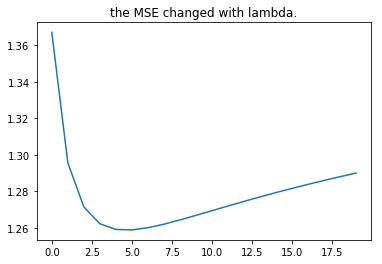

In [16]:
plt.plot(MSEs[:20])
plt.title("the MSE changed with lambda.")
plt.show()

In [17]:
X = numpy.array([features(elmt) for elmt in train_data])
y = numpy.array([elmt['overall'] for elmt in train_data])
test_data = data[1120000:1680000]
y_test = numpy.array([elmt['overall'] for elmt in test_data])
beta_u = numpy.random.random(number_of_reviewers)
beta_i = numpy.random.random(number_of_itemID)
alpha = numpy.mean(y)
alpha,beta_i,beta_u = gradient_descent(X,beta_u,beta_i,alpha,6)
predictions = [predict(elmt,beta_u,beta_i,alpha) for elmt in test_data]
MSE = compute_MSE(predictions,y_test)

In [18]:
MSE

1.2499671248909372